I want to integrate classical methods to optimize hyperparameters from quantum world.

In [1]:
# Install Qiskit Dynamics
!pip install qiskit-dynamics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.8/191.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 2.8 MB/s eta 0:00:00


In [16]:
import numpy as np
from qiskit_dynamics import Solver, Signal
from qiskit_dynamics.models import LindbladModel
from qiskit.quantum_info import Operator, Statevector, DensityMatrix, Pauli
import matplotlib.pyplot as plt


In [17]:
N = 6

x_ops = []
y_ops = []
z_ops = []
qubits = range(N)
zeros = Operator(np.zeros((2 ** N, 2 ** N)))

for i in qubits:
    X = zeros + Pauli('X')(i)
    x_ops.append(X)

    Y = zeros + Pauli('Y')(i)
    y_ops.append(Y)

    Z = zeros + Pauli('Z')(i)
    z_ops.append(Z)

In [18]:
nu_z = 4.
nu_x = 1.
J = 4.
Gamma = 4.

H = zeros
for i in qubits:
    X = x_ops[i]
    Z = z_ops[i]
    H += .5 * 2 * np.pi * nu_x * X
    H += .5 * 2 * np.pi * nu_z * Z

    if N > 1:
        j = i + 1 if i < (N - 1) else 0  # Nearest neighbors, with periodic boundary conditions
        op = zeros + Pauli('XX')(i, j)
        H += .5 * 2 * np.pi * J * op

        op = zeros + Pauli('YY')(i, j)
        H += .5 * 2 * np.pi * J * op

L_ops = []
L_sig = []
for i in qubits:
    X = x_ops[i]
    Y = y_ops[i]
    L_ops.append(np.sqrt(Gamma) * 0.5 * (X + 1j * Y))

solver = Solver(static_hamiltonian=H, static_dissipators=L_ops)



In [19]:
t_final = 8. / Gamma
tau = .01

# A density matrix with all qubits in ground state
y0 = DensityMatrix.from_label('0' * N)

n_steps = int(np.ceil(t_final / tau)) + 1
t_eval = np.linspace(0., t_final, n_steps)

sol = solver.solve(t_span=[0., t_final], y0=y0, t_eval=t_eval)

In [20]:
n_times = len(sol.y)
x_data = np.zeros((N, n_times))
y_data = np.zeros((N, n_times))
z_data = np.zeros((N, n_times))
x_mean = np.zeros((n_times,))
y_mean = np.zeros((n_times,))
z_mean = np.zeros((n_times,))

for t_i, sol_t in enumerate(sol.y):
    for qubit, obs in enumerate(x_ops):
        x_data[qubit, t_i] = sol_t.expectation_value(obs).real
    x_mean[t_i] = np.mean(x_data[:, t_i])

    for qubit, obs in enumerate(y_ops):
        y_data[qubit, t_i] = sol_t.expectation_value(obs).real
    y_mean[t_i] = np.mean(y_data[:, t_i])

    for qubit, obs in enumerate(z_ops):
        z_data[qubit, t_i] = sol_t.expectation_value(obs).real
    z_mean[t_i] = np.mean(z_data[:, t_i])

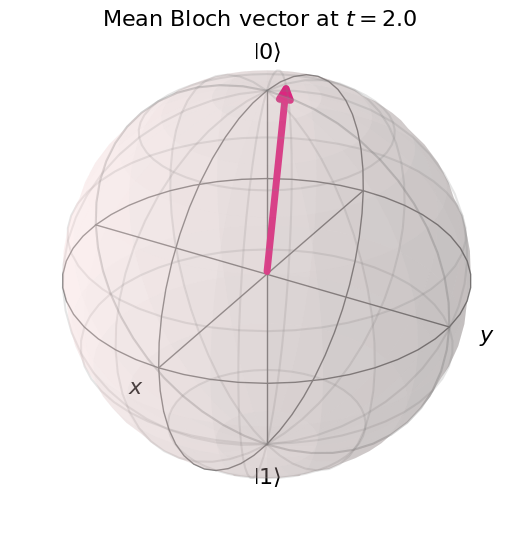

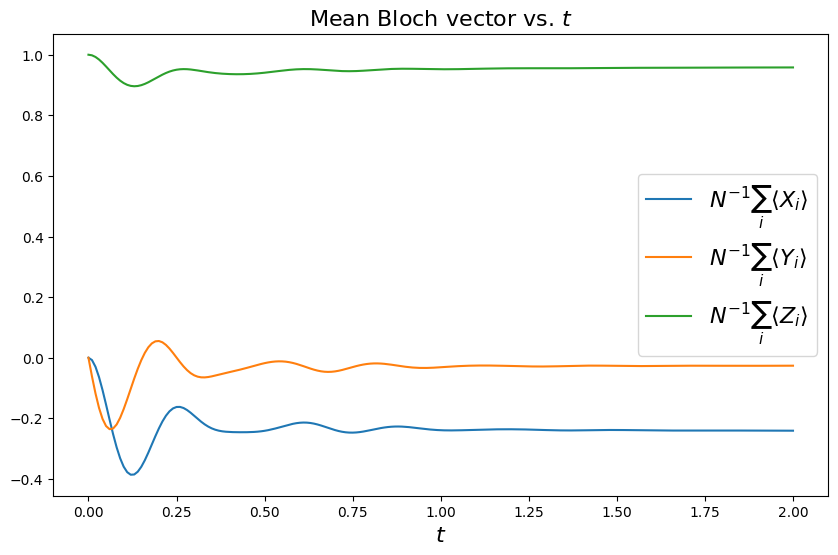

In [21]:
from qiskit.visualization import plot_bloch_vector
import matplotlib.pyplot as plt
%matplotlib inline

fontsize = 16

_, ax = plt.subplots(figsize = (10, 6))
plt.rcParams.update({'font.size': fontsize})
plt.plot(t_eval, x_mean, label = '$ N^{-1}\sum_i \\langle X_i \\rangle$')
plt.plot(t_eval, y_mean, label = '$ N^{-1}\sum_i \\langle Y_i \\rangle$')
plt.plot(t_eval, z_mean, label = '$ N^{-1}\sum_i \\langle Z_i \\rangle$')
plt.legend(fontsize = fontsize)
ax.set_xlabel('$t$', fontsize = fontsize)
ax.set_title('Mean Bloch vector vs. $t$', fontsize = fontsize)

display(plot_bloch_vector([x_mean[-1], y_mean[-1], z_mean[-1]],
                  f'Mean Bloch vector at $t = {t_eval[-1]}$'))

if N > 1 and ((abs(x_mean[-1]) > 1e-5 and abs(x_data[0, -1] / x_mean[-1] - 1) > 1e-5 or
              (abs(z_mean[-1]) > 1e-5 and abs(z_data[1, -1] / z_mean[-1] - 1) > 1e-5))):
    print("The solution at the final time appears to break translation invariance. "
          "The precision of the simulation should be examined.")